In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from cxr_analysis import load_results_from_log, get_cxr14_rocs_from_log

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Loading reproduce-chexnet data from file
reproduce_chexnet_results_path = '../analysis_data/reproduce_chexnet_aucs.csv'
reproduce_chexnet_results = pd.read_csv(reproduce_chexnet_results_path, 
                                        index_col='LABEL', names=['LABEL','CHEXNET-ORIG', 'CHEXNET-REPRODUCE'],
                                        header=1)
reproduce_chexnet_results.index = reproduce_chexnet_results.index.str.upper()

In [3]:
# Specify log directory to pull results from
log_base_dir = '/lfs/1/jdunnmon/repos/metal/logs/2019_04_13'
logs_to_load = {
                'MTL-224':'baseline_chexnet_equivalent_results',
                'MTL-224-DRAIN':'baseline_chexnet_equivalent_results_with_drain',
               # 'MTL-512':'baseline_chexnet_equivalent_results_512', # GET WHEN FINISHED
                'MTL-512-DRAIN':'baseline_chexnet_equivalent_results_with_drain_512',
                }

df_compare = reproduce_chexnet_results
for name, log in logs_to_load.items():
    # Loading all json logs
    results = load_results_from_log(os.path.join(log_base_dir,log))
    df_compare = get_cxr14_rocs_from_log(df_compare, results['metrics'], col_name=name)
    

In [4]:
df_compare.round(3)

,CHEXNET-ORIG,CHEXNET-REPRODUCE,MTL-224,MTL-224-DRAIN,MTL-512-DRAIN
LABEL,,,,,
CARDIOMEGALY,0.910,0.925,0.915,0.910,0.900
CONSOLIDATION,0.801,0.790,0.809,0.808,0.799
EDEMA,0.898,0.888,0.897,0.897,0.890
EFFUSION,0.884,0.864,0.884,0.880,0.883
EMPHYSEMA,0.923,0.937,0.914,0.917,0.930
FIBROSIS,0.829,0.805,0.824,0.799,0.835
HERNIA,0.901,0.916,0.925,0.917,0.913
INFILTRATION,0.708,0.734,0.706,0.714,0.713
MASS,0.831,0.868,0.845,0.842,0.831


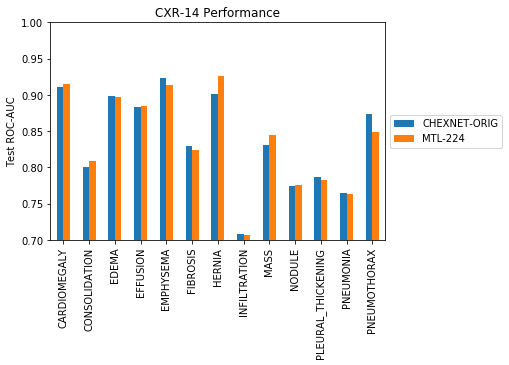

In [26]:
import matplotlib.pyplot as plt
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
#ax = df_compare.plot.bar(rot=45)

models_to_plot = ['CHEXNET-ORIG','MTL-224']
df_plot = df_compare[models_to_plot]
f = plt.figure('ROC-AUC')
plt.title('CXR-14 Performance', color='black')
plt.ylabel('Test ROC-AUC')
plot = df_plot.plot(kind='bar', ax=f.gca(),rot=90)
plot.set_xlabel('')
plot.set_ylim([0.7, 1.0])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('../figures/CXR14-performance-mtl-chexnet-224.png',format='png', bbox_inches='tight')
plt.show()

In [73]:
# TO DO
# BAR GRAPH BY COLUMN -- BY RESOLUTION, BY WITHOUT SLICE
# BAR GRAPH BY COLUMN -- PNEUMOTHORAX + SLICE